
# Effect of transforming the targets in regression model

In this example, we give an overview of
:class:`~sklearn.compose.TransformedTargetRegressor`. We use two examples
to illustrate the benefit of transforming the targets before learning a linear
regression model. The first example uses synthetic data while the second
example is based on the Ames housing data set.


In [1]:
# Author: Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

print(__doc__)

Automatically created module for IPython interactive environment


## Synthetic example

 A synthetic random regression dataset is generated. The targets ``y`` are
 modified by:

   1. translating all targets such that all entries are
      non-negative (by adding the absolute value of the lowest ``y``) and
   2. applying an exponential function to obtain non-linear
      targets which cannot be fitted using a simple linear model.

 Therefore, a logarithmic (`np.log1p`) and an exponential function
 (`np.expm1`) will be used to transform the targets before training a linear
 regression model and using it for prediction.



In [10]:
import numpy as np

from sklearn.datasets import make_regression

X, y = make_regression(n_samples=10_000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

Below we plot the probability density functions of the target
before and after applying the logarithmic functions.



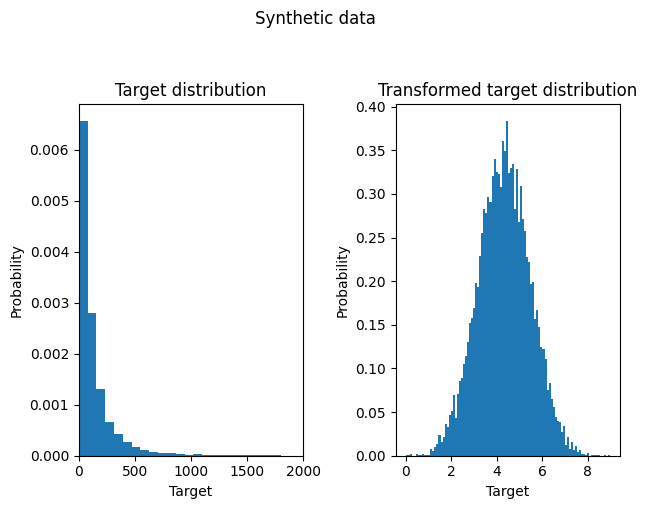

In [11]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 2000])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

At first, a linear model will be applied on the original targets. Due to the
non-linearity, the model trained will not be precise during
prediction. Subsequently, a logarithmic function is used to linearize the
targets, allowing better prediction even with a similar linear model as
reported by the median absolute error (MedAE).



In [12]:
from sklearn.metrics import median_absolute_error, r2_score


def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }

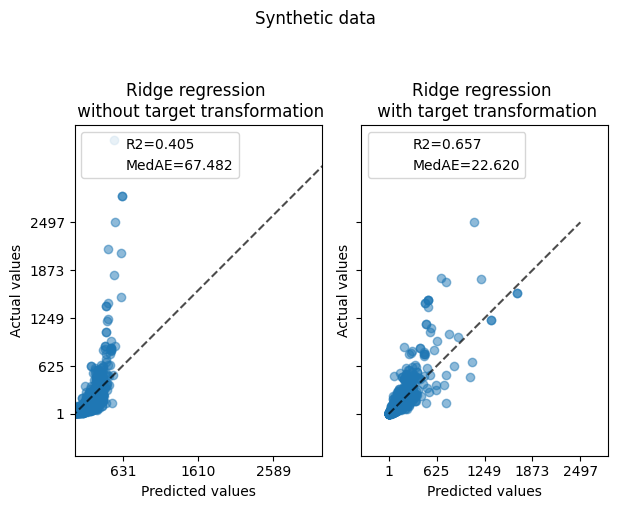

In [19]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0,
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax1,
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0, ax1], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0.set_title("Ridge regression \n without target transformation")
ax1.set_title("Ridge regression \n with target transformation")
f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()

## Real-world data set

 In a similar manner, the Ames housing data set is used to show the impact
 of transforming the targets before learning a model. In this example, the
 target to be predicted is the selling price of each house.



In [20]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import quantile_transform

ames = fetch_openml(name="house_prices", as_frame=True)
# Keep only numeric columns
X = ames.data.select_dtypes(np.number)
# Remove columns with NaN or Inf values
X = X.drop(columns=["LotFrontage", "GarageYrBlt", "MasVnrArea"])
# Let the price be in k$
y = ames.target / 1000
y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


A :class:`~sklearn.preprocessing.QuantileTransformer` is used to normalize
the target distribution before applying a
:class:`~sklearn.linear_model.RidgeCV` model.



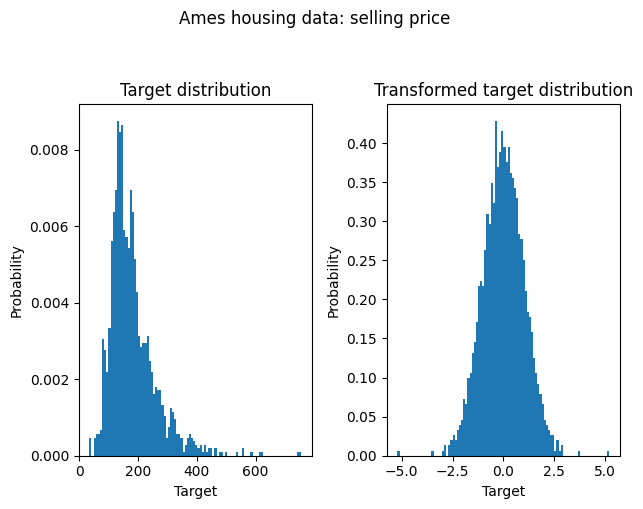

In [22]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

The effect of the transformer is weaker than on the synthetic data. However,
the transformation results in an increase in $R^2$ and large decrease
of the MedAE. The residual plot (predicted target - true target vs predicted
target) without target transformation takes on a curved, 'reverse smile'
shape due to residual values that vary depending on the value of predicted
target. With target transformation, the shape is more linear indicating
better model fit.



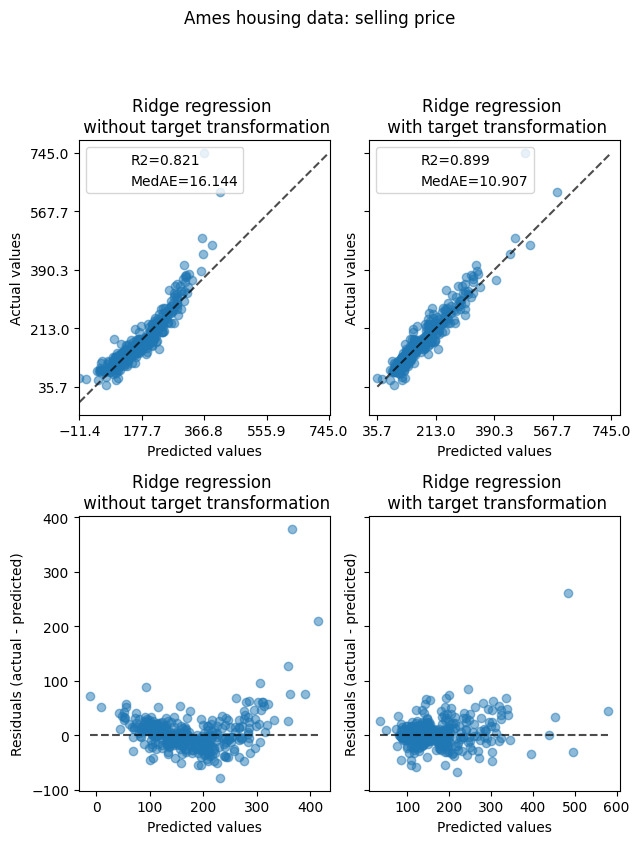

In [24]:
from sklearn.preprocessing import QuantileTransformer

f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

ridge_cv = RidgeCV().fit(X_train, y_train)
y_pred_ridge = ridge_cv.predict(X_test)

ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
).fit(X_train, y_train)
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test)

# plot the actual vs predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)

# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1]], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0[0].set_title("Ridge regression \n without target transformation")
ax0[1].set_title("Ridge regression \n with target transformation")

# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_ridge_with_trans_target,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("Ridge regression \n without target transformation")
ax1[1].set_title("Ridge regression \n with target transformation")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()
plt.show()

### QuantileTransformer for the Target Variable

The `QuantileTransformer` is a preprocessing tool in scikit-learn that transforms the distribution of a dataset to follow a uniform or normal distribution. When applied to the target variable $y$ in regression tasks, it can help stabilize variance and make the model more robust, especially when the target variable exhibits significant skewness or outliers.

#### Mathematical Transformation

Given a target variable $y$, the `QuantileTransformer` maps the quantiles of the original distribution to the quantiles of the desired output distribution. The main steps involved are:

1. **Quantile Calculation**:
   - Compute the empirical cumulative distribution function (ECDF) of $y$. For a given value $y_i$ in $y$, the ECDF is calculated as:
     $$
     F(y_i) = \frac{1}{N} \sum_{j=1}^{N} \mathbf{1}(y_j \leq y_i)
     $$
     where $N$ is the number of samples, and $\mathbf{1}$ is the indicator function.

2. **Mapping to Target Distribution**:
   - The quantile value $F(y_i)$ is then mapped to the corresponding quantile in the desired output distribution (e.g., normal distribution). If the target distribution is normal, the transformation can be expressed as:
     $$
     y_i' = \Phi^{-1}(F(y_i))
     $$
     where $\Phi^{-1}$ is the inverse cumulative distribution function (quantile function) of the normal distribution.

#### Impact on the Model

Applying a `QuantileTransformer` to the target variable can have several effects on the model:

- **Variance Stabilization**: By transforming the target variable to follow a normal distribution, the variance of the target variable can be stabilized, making the regression model less sensitive to extreme values.
- **Improved Model Performance**: The transformation can lead to improved model performance by ensuring that the assumptions of linear regression (such as normally distributed residuals) are better satisfied.
- **Robustness to Outliers**: The transformation reduces the impact of outliers by mapping them to less extreme values in the transformed space.

#### Main Arguments

- **n_quantiles**: Number of quantiles used to compute the empirical cumulative distribution function. A higher number of quantiles leads to a finer approximation of the distribution.
- **output_distribution**: The desired distribution for the output. Common choices are 'uniform' and 'normal'. For transforming the target variable, 'normal' is often chosen to achieve a normal distribution.
- **subsample**: The maximum number of samples to use when fitting the transformer. Reducing the subsample size can speed up the transformation at the cost of accuracy.
- **random_state**: Controls the randomness of the subsampling (if subsample is set) and ensures reproducibility of the transformation.

### Example Scenario

In the provided scenario, the target variable $y$ (e.g., selling price of houses) is transformed using `QuantileTransformer` with a normal output distribution:

- **Without Transformation**: The model might struggle with skewed data, leading to suboptimal performance.
- **With Transformation**: The target variable is transformed to follow a normal distribution, improving the model's ability to learn and predict by ensuring more stable and normally distributed residuals.

### Conclusion

Using `QuantileTransformer` to preprocess the target variable in regression tasks can significantly improve model performance by stabilizing variance and reducing the impact of outliers. It is a powerful technique to ensure that the assumptions of linear regression models are better met, leading to more robust and accurate predictions.
